# **Modeling and Evaluation Notebook using conventional ML**

## Objectives

* Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

current_dir = os.getcwd()
current_dir

'c:\\Users\\Andrias\\Desktop\\patient-readmission\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Andrias\\Desktop\\patient-readmission'

# Load Data

In [4]:
import pandas as pd
import numpy as np

data_path = 'outputs/datasets/collection/HospitalReadmissions.csv'

df = pd.read_csv(data_path).drop(labels=['medical_specialty'], axis=1)
df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Circulatory,Respiratory,Other,no,no,no,yes,0
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,no,no,no,yes,0
2,[50-60),5,45,0,18,0,0,0,Circulatory,Circulatory,Circulatory,no,no,yes,yes,1
3,[70-80),2,36,0,12,1,0,0,Circulatory,Other,Diabetes,no,no,yes,yes,1
4,[60-70),1,42,0,7,0,0,0,Other,Circulatory,Respiratory,no,no,no,yes,0


---

## ML Pipeline with Data

### ML pipeline for Data Cleaning and Feature Engineering

In [30]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OneHotEncoder
from feature_engine.outliers import Winsorizer


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("OneHotEncoder", OneHotEncoder(variables=[
            'age','diag_1','diag_2','diag_3','glucose_test','A1Ctest','change','diabetes_med'])),
        ('Winsorizer_iqr', Winsorizer(variables=[
            'time_in_hospital', 'n_procedures','n_inpatient', 'n_medications','n_lab_procedures'],
                                capping_method='iqr', tail='both', fold=1.5)),
        ('Winsorizer_gaussian', Winsorizer(variables=['n_emergency', 'n_outpatient'],
                                capping_method='gaussian', tail='both', fold=3)),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
        method="spearman", threshold=0.45, selection_method="variance")),

    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('OneHotEncoder',
                 OneHotEncoder(variables=['age', 'diag_1', 'diag_2', 'diag_3',
                                          'glucose_test', 'A1Ctest', 'change',
                                          'diabetes_med'])),
                ('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['time_in_hospital', 'n_procedures',
                                       'n_inpatient', 'n_medications',
                                       'n_lab_procedures'])),
                ('Winsorizer_gaussian',
                 Winsorizer(fold=3, tail='both',
                            variables=['n_emergency', 'n_outpatient'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.45))])

### ML Pipeline for Modelling and Hyperparameter Optimisation

In [31]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Custom Class for Hyperparameter Optimisation

In [33]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                            verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Split Train and Test set

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['readmitted'], axis=1),
                                                    df['readmitted'],
                                                    test_size=0.3,
                                                    random_state=0)

print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(17500, 15) (17500,) (7500, 15) (7500,)


Data cleaning pipeline

In [35]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(17500, 38) (17500,) (7500, 38) (7500,)


Handle Target Imbalance

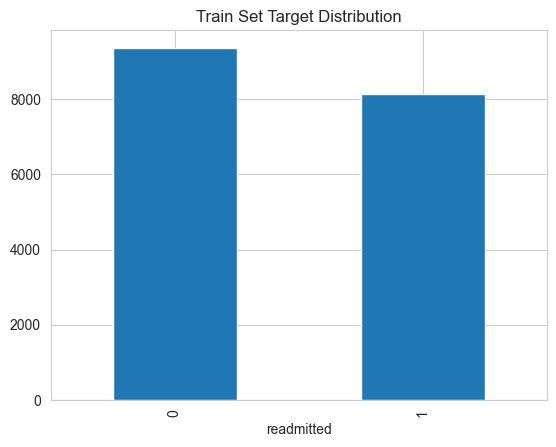

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [37]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(18732, 38) (18732,) (7500, 38) (7500,)


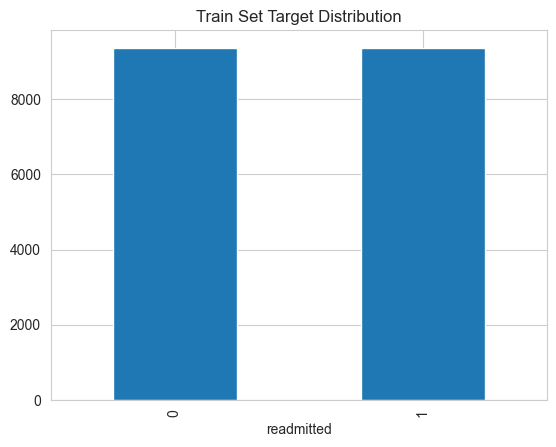

In [38]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

### Grid Search CV - Sklearn

In [39]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "LogisticRegression": LogisticRegression(random_state=0)
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
    "LogisticRegression": {}
}

Quick GridSearch CV - Binary Classifier

In [40]:
import warnings
from sklearn.metrics import make_scorer, recall_score

warnings.filterwarnings("ignore")

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
        scoring =  make_scorer(recall_score, pos_label=1),
        n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [41]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,RandomForestClassifier,0.509605,0.567591,0.710625,0.073213
5,ExtraTreesClassifier,0.509605,0.563854,0.709557,0.073798
2,DecisionTreeClassifier,0.479189,0.530541,0.653497,0.062659
4,GradientBoostingClassifier,0.45275,0.492849,0.527496,0.02931
6,AdaBoostClassifier,0.441004,0.470214,0.500267,0.022378
1,XGBClassifier,0.409503,0.46626,0.517352,0.039698
0,LogisticRegression,0.139808,0.251453,0.493326,0.128679


Extensive search on the most suitable algorithms

In [87]:
models_search = {
    "RandomForestClassifier":RandomForestClassifier(random_state=0),
    "ExtraTreesClassifier":ExtraTreesClassifier(random_state=0),
    "DecisionTreeClassifier":DecisionTreeClassifier(random_state=0)
}

params_search = {
    "RandomForestClassifier":{'model__n_estimators': [100,50,140],
                            'model__max_depth': [None,4, 15],
                            'model__min_samples_split': [2,50],
                            'model__min_samples_leaf': [1,50],
                            'model__max_leaf_nodes': [None,50],
                            },
    "ExtraTreesClassifier":{'model__n_estimators': [100,50,150],
                        'model__max_depth': [None, 3, 15],
                        'model__min_samples_split': [2, 50],
                        'model__min_samples_leaf': [1,50],
                        },
    "DecisionTreeClassifier":{'model__max_depth': [None,4, 15],
                            'model__min_samples_split': [2,50],
                            'model__min_samples_leaf': [1,50],
                            'model__max_leaf_nodes': [None,50],
                            }
}

In [43]:
from sklearn.metrics import recall_score, make_scorer

search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
        scoring =  make_scorer(recall_score, pos_label=1),
        n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 72 candidates, totalling 360 fits



Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [44]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
2,RandomForestClassifier,0.508538,0.5693,0.71543,0.075415,None,None,1,2,140
0,RandomForestClassifier,0.509605,0.567591,0.710625,0.073213,None,None,1,2,100
72,ExtraTreesClassifier,0.509605,0.563854,0.709557,0.073798,None,NaN,1,2,100
74,ExtraTreesClassifier,0.506403,0.563213,0.708489,0.074271,None,NaN,1,2,150
1,RandomForestClassifier,0.495731,0.556487,0.697811,0.07271,None,None,1,2,50
...,...,...,...,...,...,...,...,...,...,...
92,ExtraTreesClassifier,0.454885,0.482062,0.509877,0.018697,3,NaN,50,2,150
95,ExtraTreesClassifier,0.454885,0.482062,0.509877,0.018697,3,NaN,50,50,150
86,ExtraTreesClassifier,0.45275,0.481741,0.508809,0.019284,3,NaN,1,2,150
89,ExtraTreesClassifier,0.45275,0.481314,0.509343,0.01947,3,NaN,1,50,150


In [45]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

In [46]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

In [47]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(n_estimators=140, random_state=0))])

In [48]:
X_train.head()

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,age_[80-90),age_[70-80),age_[50-60),...,diag_3_Other,diag_3_Respiratory,diag_3_Diabetes,diag_3_Musculoskeletal,diag_3_Injury,diag_3_Digestive,diag_3_Missing,glucose_test_no,A1Ctest_no,change_no
0,4,70,0,6.0,0.0,2.5,0.0,1,0,0,...,0,0,0,0,0,0,0,1,1,1
1,6,52,1,8.0,0.0,0.0,0.0,0,1,0,...,1,0,0,0,0,0,0,1,1,1
2,6,49,1,13.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,1,1,0
3,2,55,0,6.0,2.0,0.0,0.0,0,0,1,...,0,0,1,0,0,0,0,1,1,0
4,4,62,0,14.0,0.0,0.0,0.0,0,1,0,...,0,0,0,0,0,0,0,1,1,1


* These are the 6 most important features in descending order. The model was trained on them: 
['n_lab_procedures', 'n_medications', 'time_in_hospital', 'n_inpatient', 'n_procedures', 'n_outpatient']


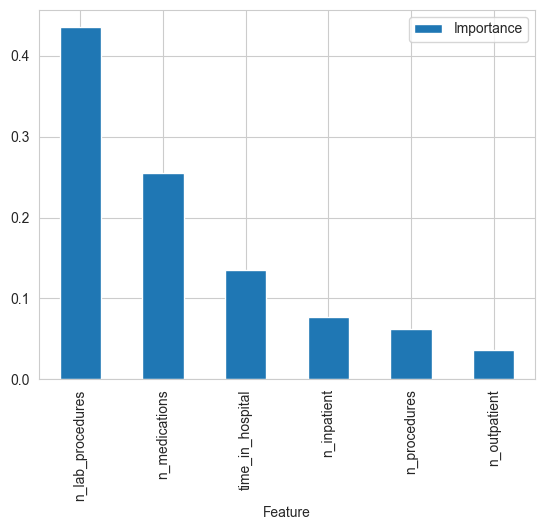

In [49]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Pipeline on Train and Test sets

In [50]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[["Actual " + sub for sub in label_map]],
        index=[["Prediction " + sub for sub in label_map]]
        ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [51]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['Not Readmitted', 'Readmitted'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                          Actual Not Readmitted Actual Readmitted
Prediction Not Readmitted                  9064               398
Prediction Readmitted                       302              8968


---  Classification Report  ---
                precision    recall  f1-score   support

Not Readmitted       0.96      0.97      0.96      9366
    Readmitted       0.97      0.96      0.96      9366

      accuracy                           0.96     18732
     macro avg       0.96      0.96      0.96     18732
  weighted avg       0.96      0.96      0.96     18732
 

#### Test Set ####

---  Confusion Matrix  ---
                          Actual Not Readmitted Actual Readmitted
Prediction Not Readmitted                  2281              1706
Prediction Readmitted                      1599              1914


---  Classification Report  ---
                precision    recall  f1-score   support

Not Readmitted       0.57      0.59      0

### Refit pipeline with best features

In [52]:
best_features

['n_lab_procedures',
 'n_medications',
 'time_in_hospital',
 'n_inpatient',
 'n_procedures',
 'n_outpatient']

In [66]:
def PipelineDataCleaningAndFeatureEngineeringBestFeatures():
    pipeline_base = Pipeline([
        ('Winsorizer_iqr', Winsorizer(variables=[
            'time_in_hospital', 'n_procedures','n_inpatient', 'n_medications','n_lab_procedures'],
                                capping_method='iqr', tail='both', fold=1.5)),
        ('Winsorizer_gaussian', Winsorizer(variables=['n_outpatient'],
                                capping_method='gaussian', tail='both', fold=3)),
    ])

    return pipeline_base

In [67]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

In [256]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['readmitted'], axis=1),
    df['readmitted'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20000, 15) (20000,) (5000, 15) (5000,)


In [257]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, X_test.shape)
X_train.head()

(20000, 6) (5000, 6)


,n_lab_procedures,n_medications,time_in_hospital,n_inpatient,n_procedures,n_outpatient
10263,47,21,4,1,0,0
18409,50,11,3,0,1,0
13047,66,10,4,0,1,0
21371,63,28,14,0,0,0
16392,60,25,3,2,2,3


In [258]:
pipeline_for_data_cleaning_eng = PipelineDataCleaningAndFeatureEngineeringBestFeatures()

X_train = pipeline_for_data_cleaning_eng.fit_transform(X_train)
X_test = pipeline_for_data_cleaning_eng.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20000, 6) (20000,) (5000, 6) (5000,)


### Target imbalance

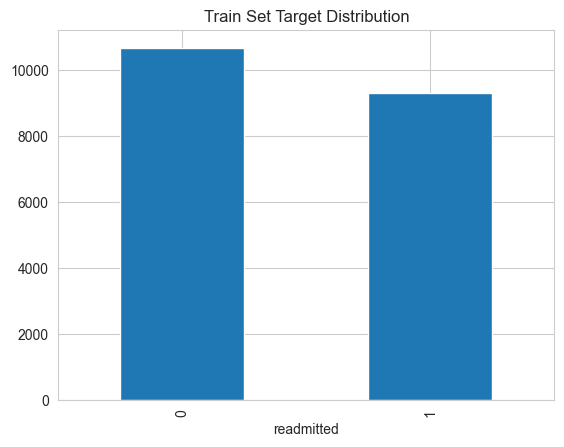

In [259]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [260]:
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21360, 6) (21360,) (5000, 6) (5000,)


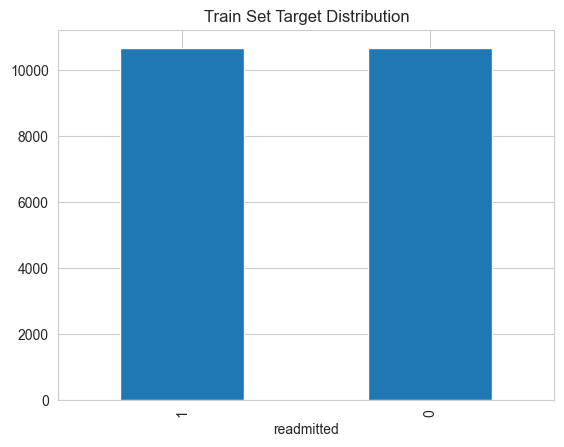

In [261]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

### GridSearch CV

In [262]:
models_search = {'RandomForestClassifier': RandomForestClassifier(random_state=0)}

In [263]:
best_parameters

{'model__max_depth': 25,
 'model__max_leaf_nodes': 500,
 'model__min_samples_leaf': 3,
 'model__min_samples_split': 2,
 'model__n_estimators': 1500}

In [271]:
params_search = {"RandomForestClassifier":{'model__max_depth': [25],
                                        'model__max_leaf_nodes': [500],
                                        'model__min_samples_leaf': [3],
                                        'model__min_samples_split': [2],
                                        'model__n_estimators': [150]
                                        }
                }

In [272]:
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                scoring=make_scorer(recall_score, pos_label=1),
                n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [273]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary.head()

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,RandomForestClassifier,0.470974,0.506929,0.524813,0.019888,25,500,3,2,150


In [274]:
best_model = grid_search_summary.iloc[0, 0]

pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=25, max_leaf_nodes=500,
                                        min_samples_leaf=3, n_estimators=150,
                                        random_state=0))])

In [275]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 25,
 'model__max_leaf_nodes': 500,
 'model__min_samples_leaf': 3,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

### Assess feature importance

* These are the 6 most important features in descending order. The model was trained on them: 
['n_inpatient', 'n_lab_procedures', 'n_medications', 'time_in_hospital', 'n_outpatient', 'n_procedures']


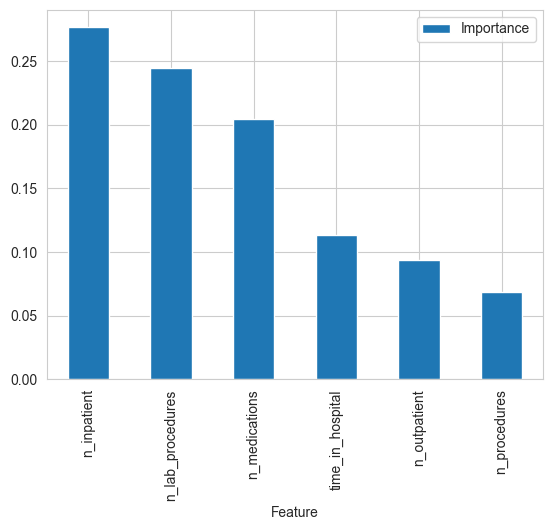

In [276]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Pipeline on Train and Test Sets

In [277]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['Not readmitted', 'readmitted'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                          Actual Not readmitted Actual readmitted
Prediction Not readmitted                  8410              4135
Prediction readmitted                      2270              6545


---  Classification Report  ---
                precision    recall  f1-score   support

Not readmitted       0.67      0.79      0.72     10680
    readmitted       0.74      0.61      0.67     10680

      accuracy                           0.70     21360
     macro avg       0.71      0.70      0.70     21360
  weighted avg       0.71      0.70      0.70     21360
 

#### Test Set ####

---  Confusion Matrix  ---
                          Actual Not readmitted Actual readmitted
Prediction Not readmitted                  1793              1229
Prediction readmitted                       773              1205


---  Classification Report  ---
                precision    recall  f1-score   support

Not readmitted       0.59      0.70      0

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
